# Tarea 2


## Modelar código con rotura, con y sin roller. Para ello se elige Thorton and Guza (1983) y Lipmann et al (1996).


--- Procesando caso: R36 ---
    -> Usando clave 'LWF.H', puntos válidos: 6
Condición contorno (offshore): Xout=23.450 m, h_out=2.206 m, Hrms_out=0.581 m
  -> E_out=4.240e+02 J/m^2, Cg_out=3.503 m/s, F_out=1.485e+03 W/m

--- Procesando caso: R38 ---
    -> Usando clave 'LWF.H', puntos válidos: 6
Condición contorno (offshore): Xout=23.450 m, h_out=2.206 m, Hrms_out=0.492 m
  -> E_out=3.042e+02 J/m^2, Cg_out=4.106 m/s, F_out=1.249e+03 W/m


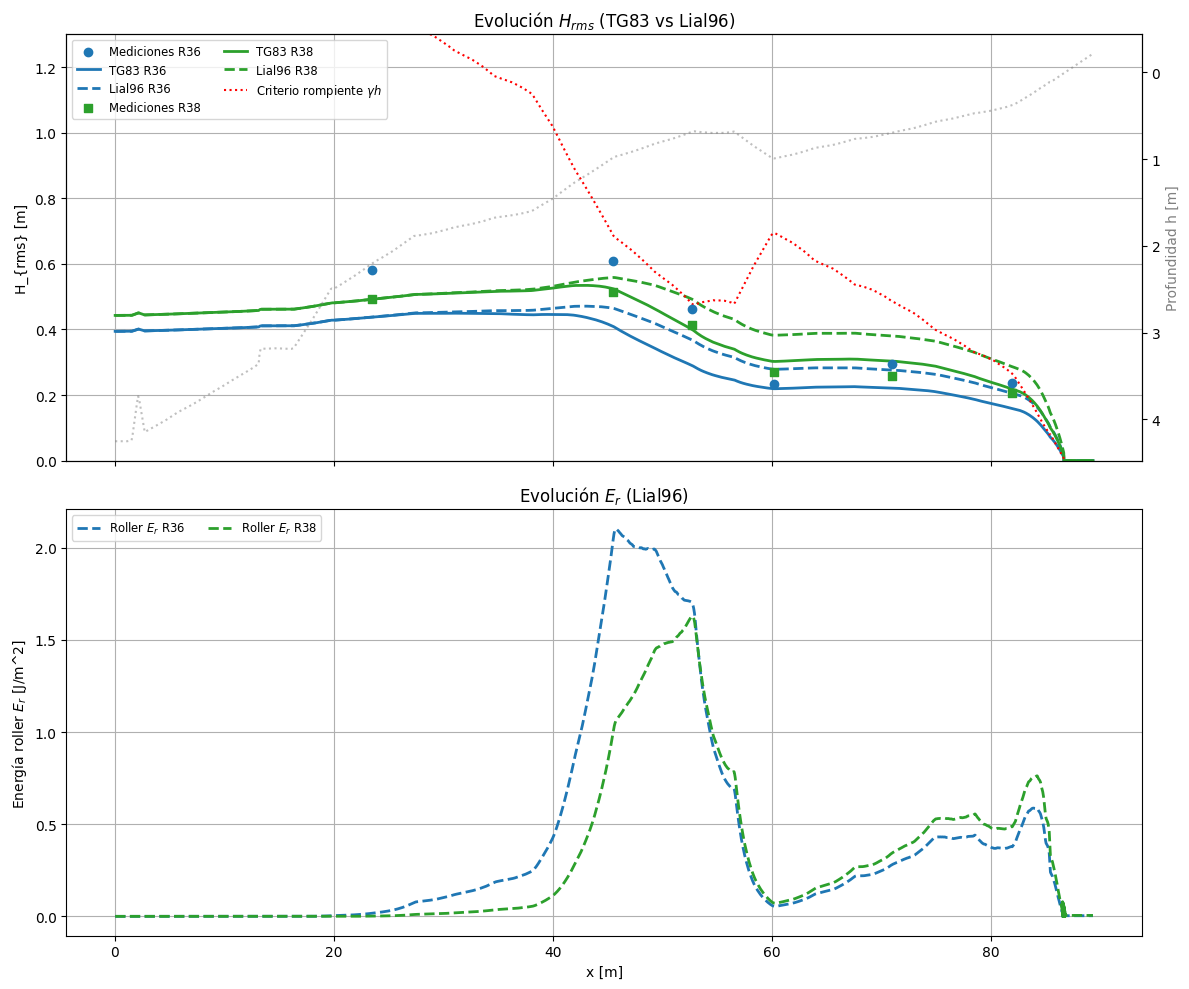

In [ ]:
# -- LIBRERÍAS NECESARIAS --
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import brentq
from scipy.special import erfc
from scipy.interpolate import interp1d

# --- PARÁMETROS ---
g = 9.81                  # gravedad
rho = 1025.0              # densidad del agua
gamma = 0.7               # criterio rompiente H_b = gamma * h
alpha_rad = np.radians(10.0)  # ángulo del roller (rad)
B_tg83 = 4.5              # coeficiente TG83
B_lial = 1.5              # factor transferencia Onda->Roller
dx_int = 0.005            # paso de integración (malla fina)
batimetria = "REU2004bathy.txt"

# Experimentos (archivos .mat con estructura RXX)
EXP = {
    "R36": {"T": 4.0, "H0": 0.63, "file": "R36.mat", "color": "tab:blue", "marker": "o"},
    "R38": {"T": 6.0, "H0": 0.47, "file": "R38.mat", "color": "tab:green", "marker": "s"},
}

# --------- FUNCIONES FÍSICAS Y NUMÉRICAS ---------

# resuelve la relación de dispersión para obtener k
def k_num(omega, h):
    if h <= 1e-8:
        return 1e-6
        # F(k) = g*k*tanh(kh) - omega^2 = 0
    def F(k): return g * k * np.tanh(k * h) - omega**2
    try:
        k = brentq(F, 1e-8, 1e3, maxiter=200)
    except Exception:
        # falla, aguas someras
        k = omega / np.sqrt(g * h)
    return max(k, 1e-8)

# velocidad de grupi Cg
def Cg(omega, k, h):
    if h <= 1e-8 or k <= 1e-12:
        return 1e-6
    c = omega / k
    kh = k * h
    if kh < 1e-6:
        return np.sqrt(g * h)
    return 0.5 * c * (1.0 + (2.0 * kh) / np.sinh(2.0 * kh))

# energía media por unidad de superficie asociada a la ola
def E_h(Hrms):
        #E = (1/8) * rho * g * H_rms^2   [J/m^2]
    return 0.125 * rho * g * (Hrms**2)

# flujo de energía
def Flux_h(E, Cg_val):
    return E * Cg_val

# función de disipación promedio D según Thornton & Guza 1983: Hrms: altura rms local (m), h: profundidad local (m),
# T: periodo (s), B: coef TG83, gamma: criterio rompiente
def Dis_TG83(Hrms, h, T, B, gamma):
    if h <= 1e-8 or Hrms <= 1e-8:
        return 0.0

    Hb = gamma * h
    if Hb <= 1e-8:
        return 0.0

    omega = 2.0 * np.pi / T
    fp = omega / (2.0 * np.pi)
    A = Hb / (np.sqrt(2.0) * Hrms)
    Qb = erfc(A)
    if Qb < 1e-12:
        return 0.0
    K = (3.0 * np.sqrt(np.pi) / 16.0) * rho * g * B * fp
    # forma dimensional de disipación TG83
    D = K * (Hrms**4 / (Hb**2)) * Qb
    # limitar D (seguridad numérica)
    return (min(D, 1e6))

#  EDO para TG83 (un solo estado: flujo F). Y_in = [F], Retorna dF/dx = -D(Hrms,h)
def EDO_TG83(x, Y_in, h, T, B, gamma):
    F_in = float(Y_in[0])
    if F_in <= 1e-12 or h <= 1e-8:
        return [0.0]
    omega = 2.0 * np.pi / T
    k = k_num(omega, h)
    cg_val = Cg(omega, k, h)
    if cg_val <= 1e-12:
        return [0.0]
    # de F se obtiene E y luego Hrms
    E = F_in / cg_val
    Hrms = np.sqrt(max(0.0, 8.0 * E / (rho * g)))
    D = Dis_TG83(Hrms, h, T, B, gamma)
    return [-float(D)]

# sistema acoplado Lippmann (Lial96):
def EDO_LIAL96(x, Y_in, h, T, alpha, gamma):
    F_w = float(Y_in[0]) # flujo de energía de la ola)
    E_r = float(Y_in[1]) # energía del roller
    if F_w <= 1e-12 or h <= 1e-8:
        return [0.0, 0.0]
    omega = 2.0 * np.pi / T
    k = k_num(omega, h)
    cg_val = Cg(omega, k, h)
    if cg_val <= 1e-12:
        return [0.0, 0.0]
    E_w = F_w / cg_val
    Hrms = np.sqrt(max(0.0, 8.0 * E_w / (rho * g)))
    c_phase = omega / k
    # 1) Transferencia onda->roller: usa la forma TG83 pero con B_lial
    D_w_to_r = Dis_TG83(Hrms, h, T, B=B_lial, gamma=gamma)
    # 2) Pérdida roller->turbulencia (Svendsen)
    tan_alpha = np.tan(alpha)
    if tan_alpha < 1e-6:
        tan_alpha = 1e-6
    D_r_to_t = (2.0 * g * E_r) / (c_phase * tan_alpha + 1e-12)
    dFw_dx = -D_w_to_r # transferencia onda->roller
    dEr_dx = (D_w_to_r - D_r_to_t) / (c_phase + 1e-12) # evolución del roller
    return [float(dFw_dx), float(dEr_dx)]

# ---------- FUNCIONES DE ENTRADA/SOLUCIÓN ----------

# carga batimetría desde un archivo texto en columnas (x z)
def cargar_batimetria(filename):
    x_model, z_model = np.loadtxt(filename, unpack=True, comments='%')
    h_model = -z_model
    h_interp = interp1d(x_model, h_model, kind='linear', fill_value='extrapolate')
    return x_model, h_model, h_interp

# lee el archivo .mat y extrae H medido y posiciones. estructura R.LWF.H
def cargar_datos_experimentales(filename, nombre, h_interp):
    data = loadmat(filename, struct_as_record=False, squeeze_me=True)
    R = data[nombre]
    clave_usada = ''
    try:
        H_medido = np.array(R.LWF.H)
        x_medido = np.array(R.xreal)
        clave_usada = 'LWF.H'
    except Exception:
        # fallback a otras variables si existen
        H_medido = np.array(R.mwhFW)
        x_medido = np.array(R.x)
        clave_usada = 'mwhFW'
    h_data = h_interp(x_medido)
    mask = (~np.isnan(H_medido)) & (h_data > 1e-6)
    if np.sum(mask) == 0:
        raise RuntimeError("No hay datos válidos tras aplicar la máscara (profundidad>0).")
    print(f"    -> Usando clave '{clave_usada}', puntos válidos: {np.sum(mask)}")
    return x_medido[mask], H_medido[mask]

# integra marchando desde offshore (i=0) hasta la costa (i=N-1). Retorna lista con arrays de estados (F) o (Fw, Er)
def solve_model(caso, EDO_func, initial_conditions, x_model_calc, h_model_calc):
    N = len(x_model_calc)
    dxs = np.diff(x_model_calc)
    # Inicia arrays (condición en i=0 -> offshore)
    if EDO_func.__name__ == 'EDO_TG83':
        F_model = np.zeros(N)
        F_model[0] = float(initial_conditions[0])
        Y_model = [F_model]
    else:
        Fw_model = np.zeros(N)
        Er_model = np.zeros(N)
        Fw_model[0] = float(initial_conditions[0])
        Er_model[0] = float(initial_conditions[1])
        Y_model = [Fw_model, Er_model]
    # Recorre: i=0 -> i=N-2, calculo i+1 usando derivada en i
    for i in range(N - 1):
        dx_local = dxs[i]
        h_local = float(h_model_calc[i])
        # valores en i (las EDO usan el estado local para calcular derivada)
        Y_prev = [Y[i] for Y in Y_model]

        if EDO_func.__name__ == 'EDO_TG83':
            dY_dx = EDO_TG83(x_model_calc[i], Y_prev, h_local, caso["T"], B=B_tg83, gamma=gamma)
            Y_model[0][i+1] = max(0.0, Y_prev[0] + dY_dx[0] * dx_local)
        else:
            dY_dx = EDO_LIAL96(x_model_calc[i], Y_prev, h_local, caso["T"], alpha=alpha_rad, gamma=gamma)
            Y_model[0][i+1] = max(0.0, Y_prev[0] + dY_dx[0] * dx_local)
            Y_model[1][i+1] = max(0.0, Y_prev[1] + dY_dx[1] * dx_local)
    return Y_model


# ----------------------- EJECUCIÓN PRINCIPAL -----------------------

# 1) Cargar batimetría y definir malla fina de cálculo
x_model, h_model, h_interp = cargar_batimetria(batimetria)
x_min_calc = x_model[h_model > 1e-6].min()
x_max_calc = x_model.max()
x_model_calc = np.arange(x_min_calc, x_max_calc + dx_int, dx_int)
h_model_calc = h_interp(x_model_calc)
resultados = {}
# impresion de lo que se está analizando
for nombre, caso in EXP.items():
    print(f"\n--- Procesando caso: {nombre} ---")
    try:
        x_data, H_data = cargar_datos_experimentales(caso["file"], nombre, h_interp)
    except Exception as e:
        print("Error leyendo experimento:", e)
        continue

    # 2) Condición de contorno: usar punto más OFFSHORE (mínimo x de las mediciones)
    Xout = float(x_data.min())
    idx_out = int(np.argmin(np.abs(x_data - Xout)))
    Hrms_out = float(H_data[idx_out])
    h_out = float(h_interp(Xout))

    omega = 2.0 * np.pi / caso["T"]
    k_out = k_num(omega, h_out)
    Cg_out = Cg(omega, k_out, h_out)
    E_out = E_h(Hrms_out)
    F_out = Flux_h(E_out, Cg_out)

    print(f"Condición contorno (offshore): Xout={Xout:.3f} m, h_out={h_out:.3f} m, Hrms_out={Hrms_out:.3f} m")
    print(f"  -> E_out={E_out:.3e} J/m^2, Cg_out={Cg_out:.3f} m/s, F_out={F_out:.3e} W/m")

    # 3) Resolver TG83
    Y_tg = solve_model(caso, EDO_TG83, [F_out], x_model_calc, h_model_calc)
    F_tg = Y_tg[0]

    # convierte F->Hrms (TG83)
    k_tg = np.array([k_num(omega, hh) if hh>1e-8 else 1e-8 for hh in h_model_calc])
    Cg_tg = np.array([Cg(omega, kk, hh) for kk, hh in zip(k_tg, h_model_calc)])
    Cg_tg[Cg_tg < 1e-8] = 1e-8
    Hrms_tg = np.sqrt(np.maximum(0.0, (8.0 * F_tg / Cg_tg) / (rho * g)))
    Hrms_tg[F_tg < 1e-12] = 0.0
    Hrms_tg[h_model_calc < 0.01] = 0.0

    # 4) Resolver Lippmann96 (Fw, Er)
    Y_lial = solve_model(caso, EDO_LIAL96, [F_out, 0.0], x_model_calc, h_model_calc)
    Fw_lial = Y_lial[0]
    Er_lial = Y_lial[1]

    Hrms_lial = np.sqrt(np.maximum(0.0, (8.0 * Fw_lial / Cg_tg) / (rho * g)))
    Hrms_lial[Fw_lial < 1e-12] = 0.0
    Hrms_lial[h_model_calc < 0.01] = 0.0

    # Guardar resultados (incluye Er_lial para diagnóstico)
    resultados[nombre] = {
        "x_data": x_data, "Hrms_data": H_data,
        "x_model": x_model_calc,
        "Hrms_tg": Hrms_tg, "Hrms_lial": Hrms_lial,
        "Er_lial": Er_lial
    }

# ----------------------- GRÁFICAS FINALES (Hrms + Er) -----------------------

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), sharex=True)

for nombre, res in resultados.items():
    caso = EXP[nombre]
    # Hrms: mediciones y modelos
    ax1.scatter(res["x_data"], res["Hrms_data"], label=f"Mediciones {nombre}", color=caso["color"], marker=caso["marker"], zorder=3)
    ax1.plot(res["x_model"], res["Hrms_tg"], color=caso["color"], linestyle='-', linewidth=2, label=f"TG83 {nombre}")
    ax1.plot(res["x_model"], res["Hrms_lial"], color=caso["color"], linestyle='--', linewidth=2, label=f"Lial96 {nombre}")

    # Er del roller (Lial96)
    ax2.plot(res["x_model"], res["Er_lial"], color=caso["color"], linestyle='--', linewidth=2, label=f"Roller $E_r$ {nombre}")

# criterio rompiente y batimetría (en ejes)
ax1.plot(x_model_calc, gamma * h_model_calc, 'r:', label=r"Criterio rompiente $\gamma h$")
ax1.set_ylabel('H_{rms} [m]')
ax1.set_ylim(0, 1.3)
ax1.set_title('Evolución $H_{rms}$ (TG83 vs Lial96)')
ax1.grid(True)
ax1.legend(loc='upper left', ncol=2, fontsize='small')

ax2.set_xlabel('x [m]')
ax2.set_ylabel('Energía roller $E_r$ [J/m^2]')
ax2.set_title('Evolución $E_r$ (Lial96)')
ax2.grid(True)
ax2.legend(loc='upper left', ncol=2, fontsize='small')

# batimetría en eje derecho del primer subplot
ax3 = ax1.twinx()
ax3.plot(x_model, h_model, color='gray', linestyle=':', alpha=0.5, label='h(x)')
ax3.invert_yaxis()
ax3.set_ylabel('Profundidad h [m]', color='gray')

plt.tight_layout()
plt.show()
